# Compute and visualize dependency maps

This notebok shows you how to compute dependency maps for different DNA LMs and visualize them for your specific sequences.

In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

## SpeciesLM Fungi

In [2]:
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from flash_attn.models.bert import BertModel, BertForPreTraining

model_path = 'species_upstream_1000_k1/'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path)
model = BertForPreTraining.from_pretrained(model_path, config)

In [3]:
device = "cuda"
model.to(device)
model.eval()

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(1408, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
    (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0): Block(
          (mixer): MHA(
            (Wqkv): FusedDense(in_features=768, out_features=2304, bias=True)
            (inner_attn): FlashSelfAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (inner_cross_attn): FlashCrossAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (out_proj): FusedDense(in_features=768, out_features=768, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (drop_path1): StochasticDepth(p=0.0, mode=row)
          (norm1): LayerNorm((768,

In [4]:
print(f'GPU Model: {torch.cuda.get_device_name(0)}')

GPU Model: NVIDIA A40


In [5]:
## Visualization functions

import seaborn as sns
import matplotlib.pyplot as plt

def plot_map_with_seq(matrix, dna_sequence,  plot_size=10, vmax=5, tick_label_fontsize=8):

    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
   
    sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, ax=ax, 
                xticklabels=False, yticklabels=False)  
    ax.set_aspect('equal')

    tick_positions = np.arange(len(dna_sequence)) + 0.5 # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()
    
def plot_map(matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):
   
    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size})

    ax.set_aspect('equal')

    plt.show()

In [7]:
#dependency map generation functions

nuc_table = {"A" : 0, "C":1, "G":2, "T":3}

def mutate_sequence(seq):
    
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'T']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def tok_func_species(x, proxy_species):
    
    res = tokenizer(proxy_species + " ".join(list(x['seq'])))

    return res


def create_dataloader(dataset, proxy_species, batch_size=64, rolling_masking=False):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(lambda x: tok_func_species(x, proxy_species=proxy_species), batched=False,  num_proc=20)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, batch_size=batch_size, num_workers = 4, shuffle = False, collate_fn=data_collator)

    return data_loader

acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ['A', 'C', 'G', 'T']]

def model_inference(model, data_loader):

    output_arrays = []
    for i, batch in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        tokens = batch['input_ids']
        # predict
        with torch.autocast(device):
            with torch.no_grad():
                outputs = model(tokens.to(device)).prediction_logits.cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgt_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    # rebuild to B, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

def compute_dependency_map(seq, proxy_species, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset, proxy_species=proxy_species)
    snp_reconstruct = model_inference(model, data_loader)
    snp_reconstruct = snp_reconstruct[:,2:-1,:] # discard the beginning of sentence token, species token and end of sentence token

     # for the logit add a small value epsilon and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    
    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    #zero main diagonal values
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0

    return dep_map

In [10]:
proxy_species = 'kazachstania_africana_cbs_2517_gca_000304475'

In [15]:
#sequence 1kb 5' of the start codon of YOR007C in S. cerevisiae
YOR007C_five_prime_seq = 'ATGTTAATTCTTTGAAATGAATACCACCTAATAAAACTATACATTTTCAAAATAACAAATTGTTATGAAACTAATAGCTAATTATCTTCTAGTGACAATAACCACTTTACTAGAAATTATTAAAAAAATACCGCGTTGAAAGACGATATAAAGTAGGAGATTAATAAATTTATATTCATATTTTCTTCAATCTAATGAAATTGAAGCGCAAGGATTGATTATGTGATAGGATGCGTGAGTAGTAATGCATGAAAAAGGAGGAAGACGTGATTATAATATATGATGTAAAATTTTGATTCCATTTTGCGGATTCCTGTATCCTCGAGGAAAGACCTCTGGCATATTATATAGGGATATTATTCCTTTACAAAAAATGGAATGAAAGAATCAAAACAAAATTGTCATGTTTGCACAATTGCGTATACCATTGCATATAATTATGTCGAAAATCATCAATATGTATGGGAATGATCATTCCATTTTTTTCACACTGGCATAATAATTTGAATATAATAATAATGGATGATGGGCATTATTGGGAAATAAAACTATGAAATTTGCTTTTAGTACGTGTATCGATAAATATCTCTAATTTTCTCAAGATCTGTTCCTCGTGGCCCAATGGTCACGGCGTCTGGCTACGAACCAGAAGATTCCAGGTTCAAGTCCTGGCGGGGAAGATTTTTTTTAACATTGAATAGAAATTACAAAGGTCTTTTATGCTATTTTAAAGGGCTATAGGCGGCATAATATTTGCTTTTAACCTTATTGTCATGACATTCTAATCACAACACTTAGCCCTTCTTTTGTATTTTTCCAAACTTTTTCAAGTCTTAAAATTTTCCCAATCGAAAAAAATGGAAGATCCGAGAAGGTTTTATTGCCCTACGCTTAATCCCAAATTTTGCCACCATATAAAATGAGTACGAGCGATATAATCGGACAACTGAATAGAAGCTTCTGACCAAGTGATATCTTATTAATACAAATCTACTGTACGATG'

In [16]:
dep_map = compute_dependency_map(YOR007C_five_prime_seq,proxy_species=proxy_species)

Map (num_proc=20):   0%|          | 0/3010 [00:00<?, ? examples/s]

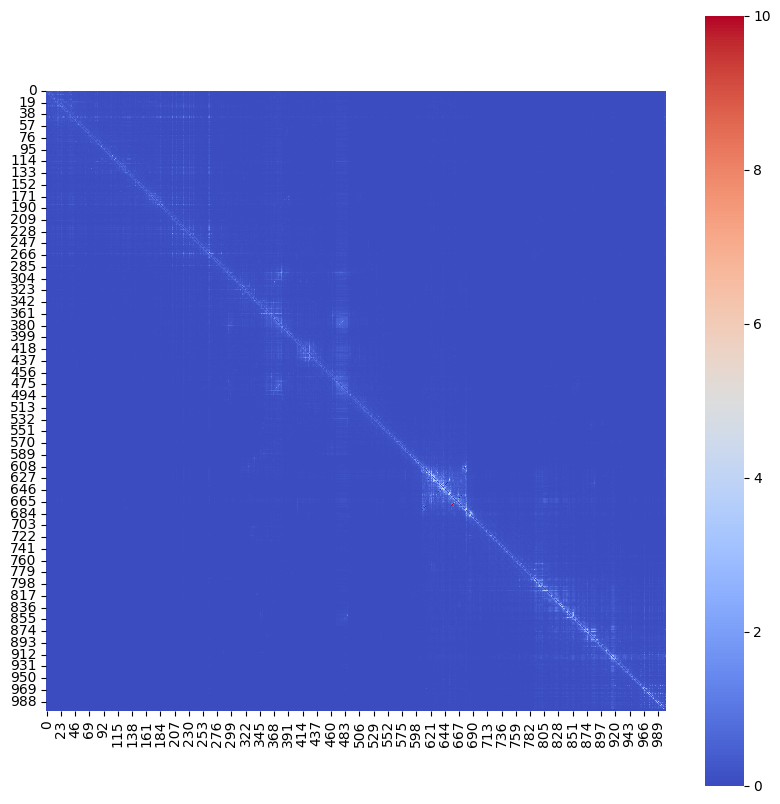

In [17]:
plot_map(dep_map, vmax=10)

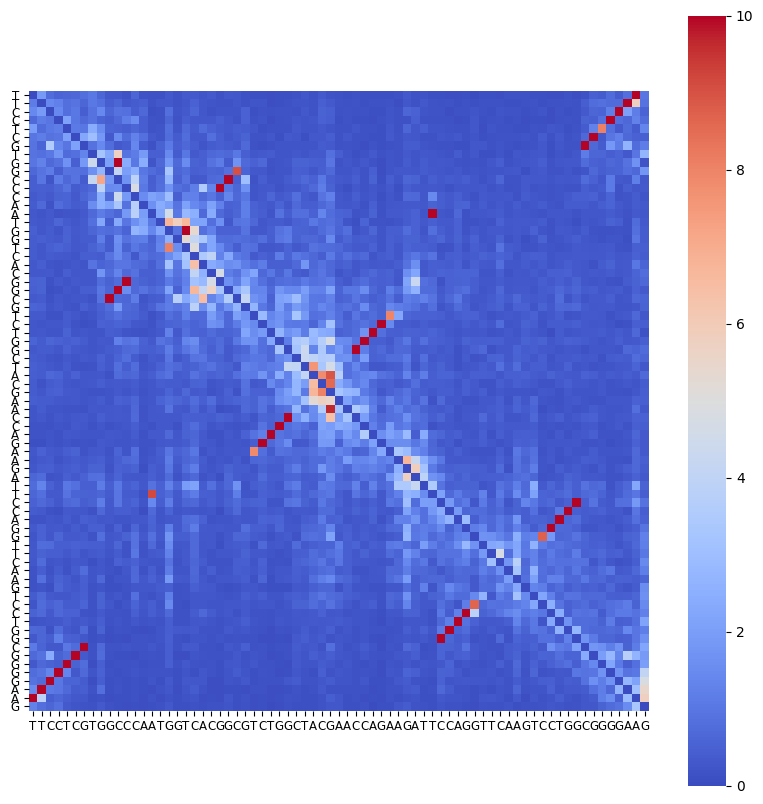

In [54]:
plot_map_with_seq(dep_map[607:680,607:680],  five_prime_seq[607: 680], vmax=10, tick_label_fontsize=8.5)

In [20]:
#sequence 1kb 5' of the start codon of SMT3 in S. cerevisiae
SMT3_five_prime_seq = 'GCTTCCCTCATTATTCCGCCCATGGCGTCTATTACCAAGCGTCATAATGTGCAATATTTGATATTATATAAGCTACTTGAGAAAGCGATAGTTTTTTTTTCTTACACAAAAAAAAAAAAACATAAAGCACCTATAACTCTCAACTTTGAAGAAGCACGAAAGGAATATGTTTAAATCAACAGAAATGTGAAAAAAATCGGTTATATATACAGAATCCGATTCTTTCTAACATCAAAGAGGTGGGGGAAGAAGGGACTCAAAAAAGAAACGACACTGCACAACCCGAGCCAAACTGACATACGAACACTAAAACCGATTTCCGAAAAAAACTTCAAATTTACATTTCATTGTCCGTCTGCCATCGCATCATCGCCTTCATCTCTAAGAGTTGCCGTGCCTTTCCATCCGCTTTCTTTTCATGCGGCGTTATTCTTTTTTCCTATTTTTGATGGTCCCTGTGCCGTTTCTTTTTCATGTTCACCGGTTTTTGGCGCCGCATACCGTACGGCGGGGCACTTTTGAAACGTTTTTGTGCATCCTGATGCCGTTTTCAAGGATCGCAAGCACGTCGCATAATACGGTAATGCCGAATTAAGGCTACGTCGTCATAGTAGGTTAGTCATGCGCGTTGGAAAAAGAAATGACCAACGCGTTGATTACGTAGTCCCCAAGGAATAATGCTTTTGAAAGTGAAAAAAAAAAATAAAACTGAAAAAAGCCATGCTGTTTCCATCACGTGCATGTCACGTTTTTGCCGCCGAACTCTTTGATCATGTGATATGAATATGTTGGGTTACCCAGCTTTGCCAACACGCGCCGTCGGAAGGTGTTCAGGAAGCAGGAAAAGAGCAAAACACCAACAATCAAACAAACGAACACATTCTACTCTTTTAGTTGATTTTTCTTACCTTTTCCAAGCTCCCGTTTCTTGTTACCACCTGTAGCATATAGGACAGAAGGACCCAGTTCAGTTCTAGTTTTACAAATAAATACACGAGCGATG'

In [21]:
dep_map = compute_dependency_map(SMT3_five_prime_seq,proxy_species=proxy_species)

Map (num_proc=20):   0%|          | 0/3010 [00:00<?, ? examples/s]

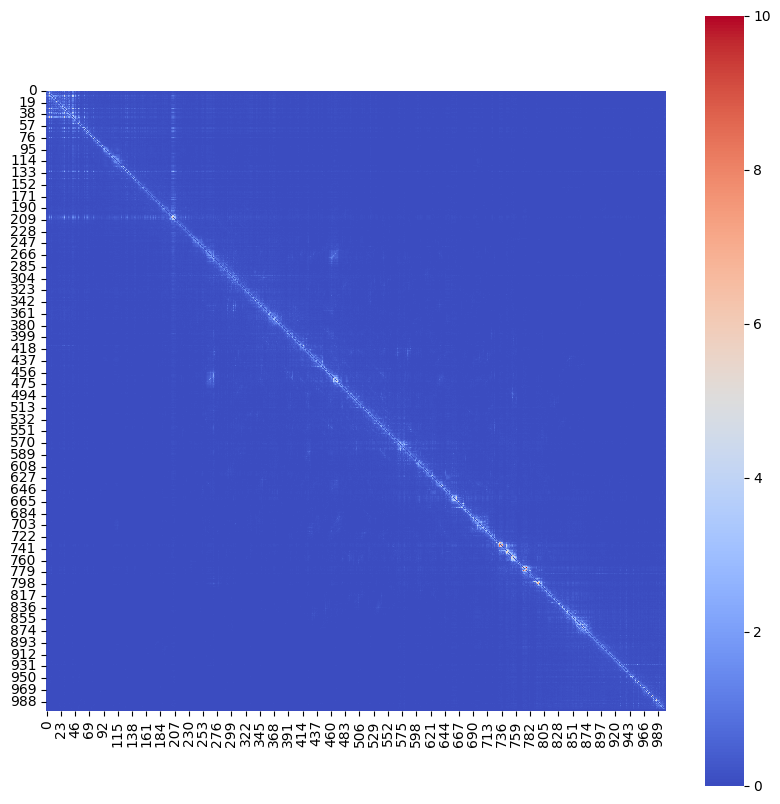

In [22]:
plot_map(dep_map, vmax=10)

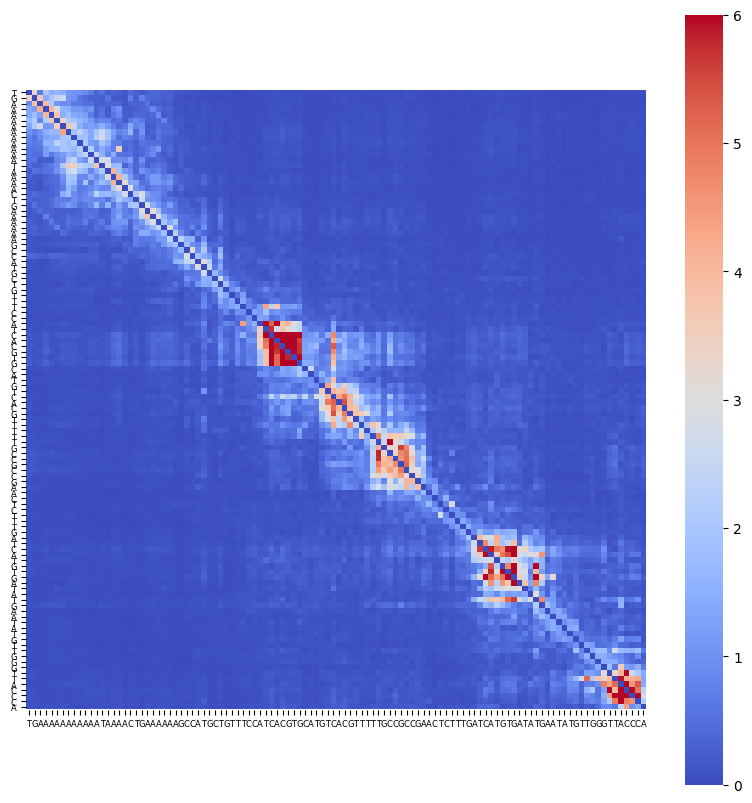

In [23]:
#SMT3 promoter in S cerevisiae
plot_map_with_seq(dep_map[690:800,690:800],  five_prime_seq[690:800], vmax=6, tick_label_fontsize=6)

## RiNALMo

In [58]:
#First download the RiNALMO files and code from their github at https://github.com/lbcb-sci/RiNALMo

In [59]:
from rinalmo.pretrained import get_pretrained_model
device = "cuda:0"
model, alphabet = get_pretrained_model(model_name="giga-v1")
model = model.to(device=device)
model.eval()

RiNALMo(
  (embedding): Embedding(22, 1280, padding_idx=1)
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mh_attn): FlashMultiHeadSelfAttention(
          (rotary_emb): RotaryEmbedding()
          (flash_self_attn): FlashAttention()
          (Wqkv): Linear(in_features=1280, out_features=3840, bias=False)
          (attention_dropout): Dropout(p=0.1, inplace=False)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=False)
        )
        (attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (transition): Sequential(
          (0): SwiGLU(
            (linear): Linear(in_features=1280, out_features=3413, bias=True)
            (linear_gate): Linear(in_features=1280, out_features=3413, bias=True)
          )
          (1): Dropout(p=0.0, inplace=False)
          (2): Linear(in_features=3413, out_features=1280, bias=True)
        )
        (out_layer_norm): LayerNorm((1280,), eps=1e-05, elemen

In [60]:
import torch
from torch.utils.data import Dataset, DataLoader

nuc_table = {"A" : 0, "C":1, "G":2, "U":3} # For RINALMo we have Us instead of Ts

def mutate_sequence(seq):
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'U']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

class RNADataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

def custom_collate_fn(batch):

    # batch is a list of sequences
    tokenized_batch = torch.tensor(alphabet.batch_tokenize(batch), 
                                   dtype=torch.int64, 
                                   device=device)
    return tokenized_batch

batch_size = 64

def create_dataloader(dataset, batch_size=batch_size):
    rna_dataset = RNADataset(list(dataset['seq'].values))
    data_loader = DataLoader(rna_dataset, 
                            batch_size=batch_size, 
                            shuffle=False,
                            collate_fn=custom_collate_fn)
    return data_loader

acgu_idxs = [5, 6, 7, 8]
def model_inference(model, data_loader):

    print(f'Inferencing {len(data_loader)} batches')
    output_arrays = []
    for i, batch_tokens in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(batch_tokens)['logits'].cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgu_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    # rebuild to nseqs, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

In [68]:
def compute_dependency_map(seq, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset)
    snp_reconstruct = model_inference(model, data_loader)
    snp_reconstruct = snp_reconstruct[:,1:-1,:] # discard the beginning of sentence token and end of sentence token

    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0


    return dep_map

In [65]:
#RFAM Bacterial RNase P class B (RF00011) -  Bacillus subtilis subsp. subtilis str. 168 RNA component of ribonuclease P (RNase P) (catalytic subunit, ribozyme)
RNA_seq = '''CUUAACGUUCGGGUAAUCGCUGCAGAUCUUGAAUCUGUAGAGGAAAGUCCAUGCUCGCACGGUGCUGAGAUGCCCGUAGU
GUUCGUGCCUAGCGAAGUCAUAAGCUAGGGCAGUCUUUAGAGGCUGACGGCAGGAAAAAAGCCUACGUCUUCGGAUAUGG
CUGAGUAUCCUUGAAAGUGCCACAGUGACGAAGUCUCACUAGAAAUGGUGAGAGUGGAACGCGGUAAACCCCUCGAGCGA
GAAACCCAAAUUUUGGUAGGGGAACCUUCUUAACGGAAUUCAACGGAGAGAAGGACAGAAUGCUUUCUGUAGAUAGAUGA
UUGCCGCCUGAGUACGAGGUGAUGAGCCGUUUGCAGUACGAUGGAACAAAACAUGGCUUACAGAACGUUAGACCAC'''.replace('\n', '')
RNA_seq

'CUUAACGUUCGGGUAAUCGCUGCAGAUCUUGAAUCUGUAGAGGAAAGUCCAUGCUCGCACGGUGCUGAGAUGCCCGUAGUGUUCGUGCCUAGCGAAGUCAUAAGCUAGGGCAGUCUUUAGAGGCUGACGGCAGGAAAAAAGCCUACGUCUUCGGAUAUGGCUGAGUAUCCUUGAAAGUGCCACAGUGACGAAGUCUCACUAGAAAUGGUGAGAGUGGAACGCGGUAAACCCCUCGAGCGAGAAACCCAAAUUUUGGUAGGGGAACCUUCUUAACGGAAUUCAACGGAGAGAAGGACAGAAUGCUUUCUGUAGAUAGAUGAUUGCCGCCUGAGUACGAGGUGAUGAGCCGUUUGCAGUACGAUGGAACAAAACAUGGCUUACAGAACGUUAGACCAC'

In [70]:
dep_map = compute_dependency_map(RNA_seq)

Inferencing 19 batches


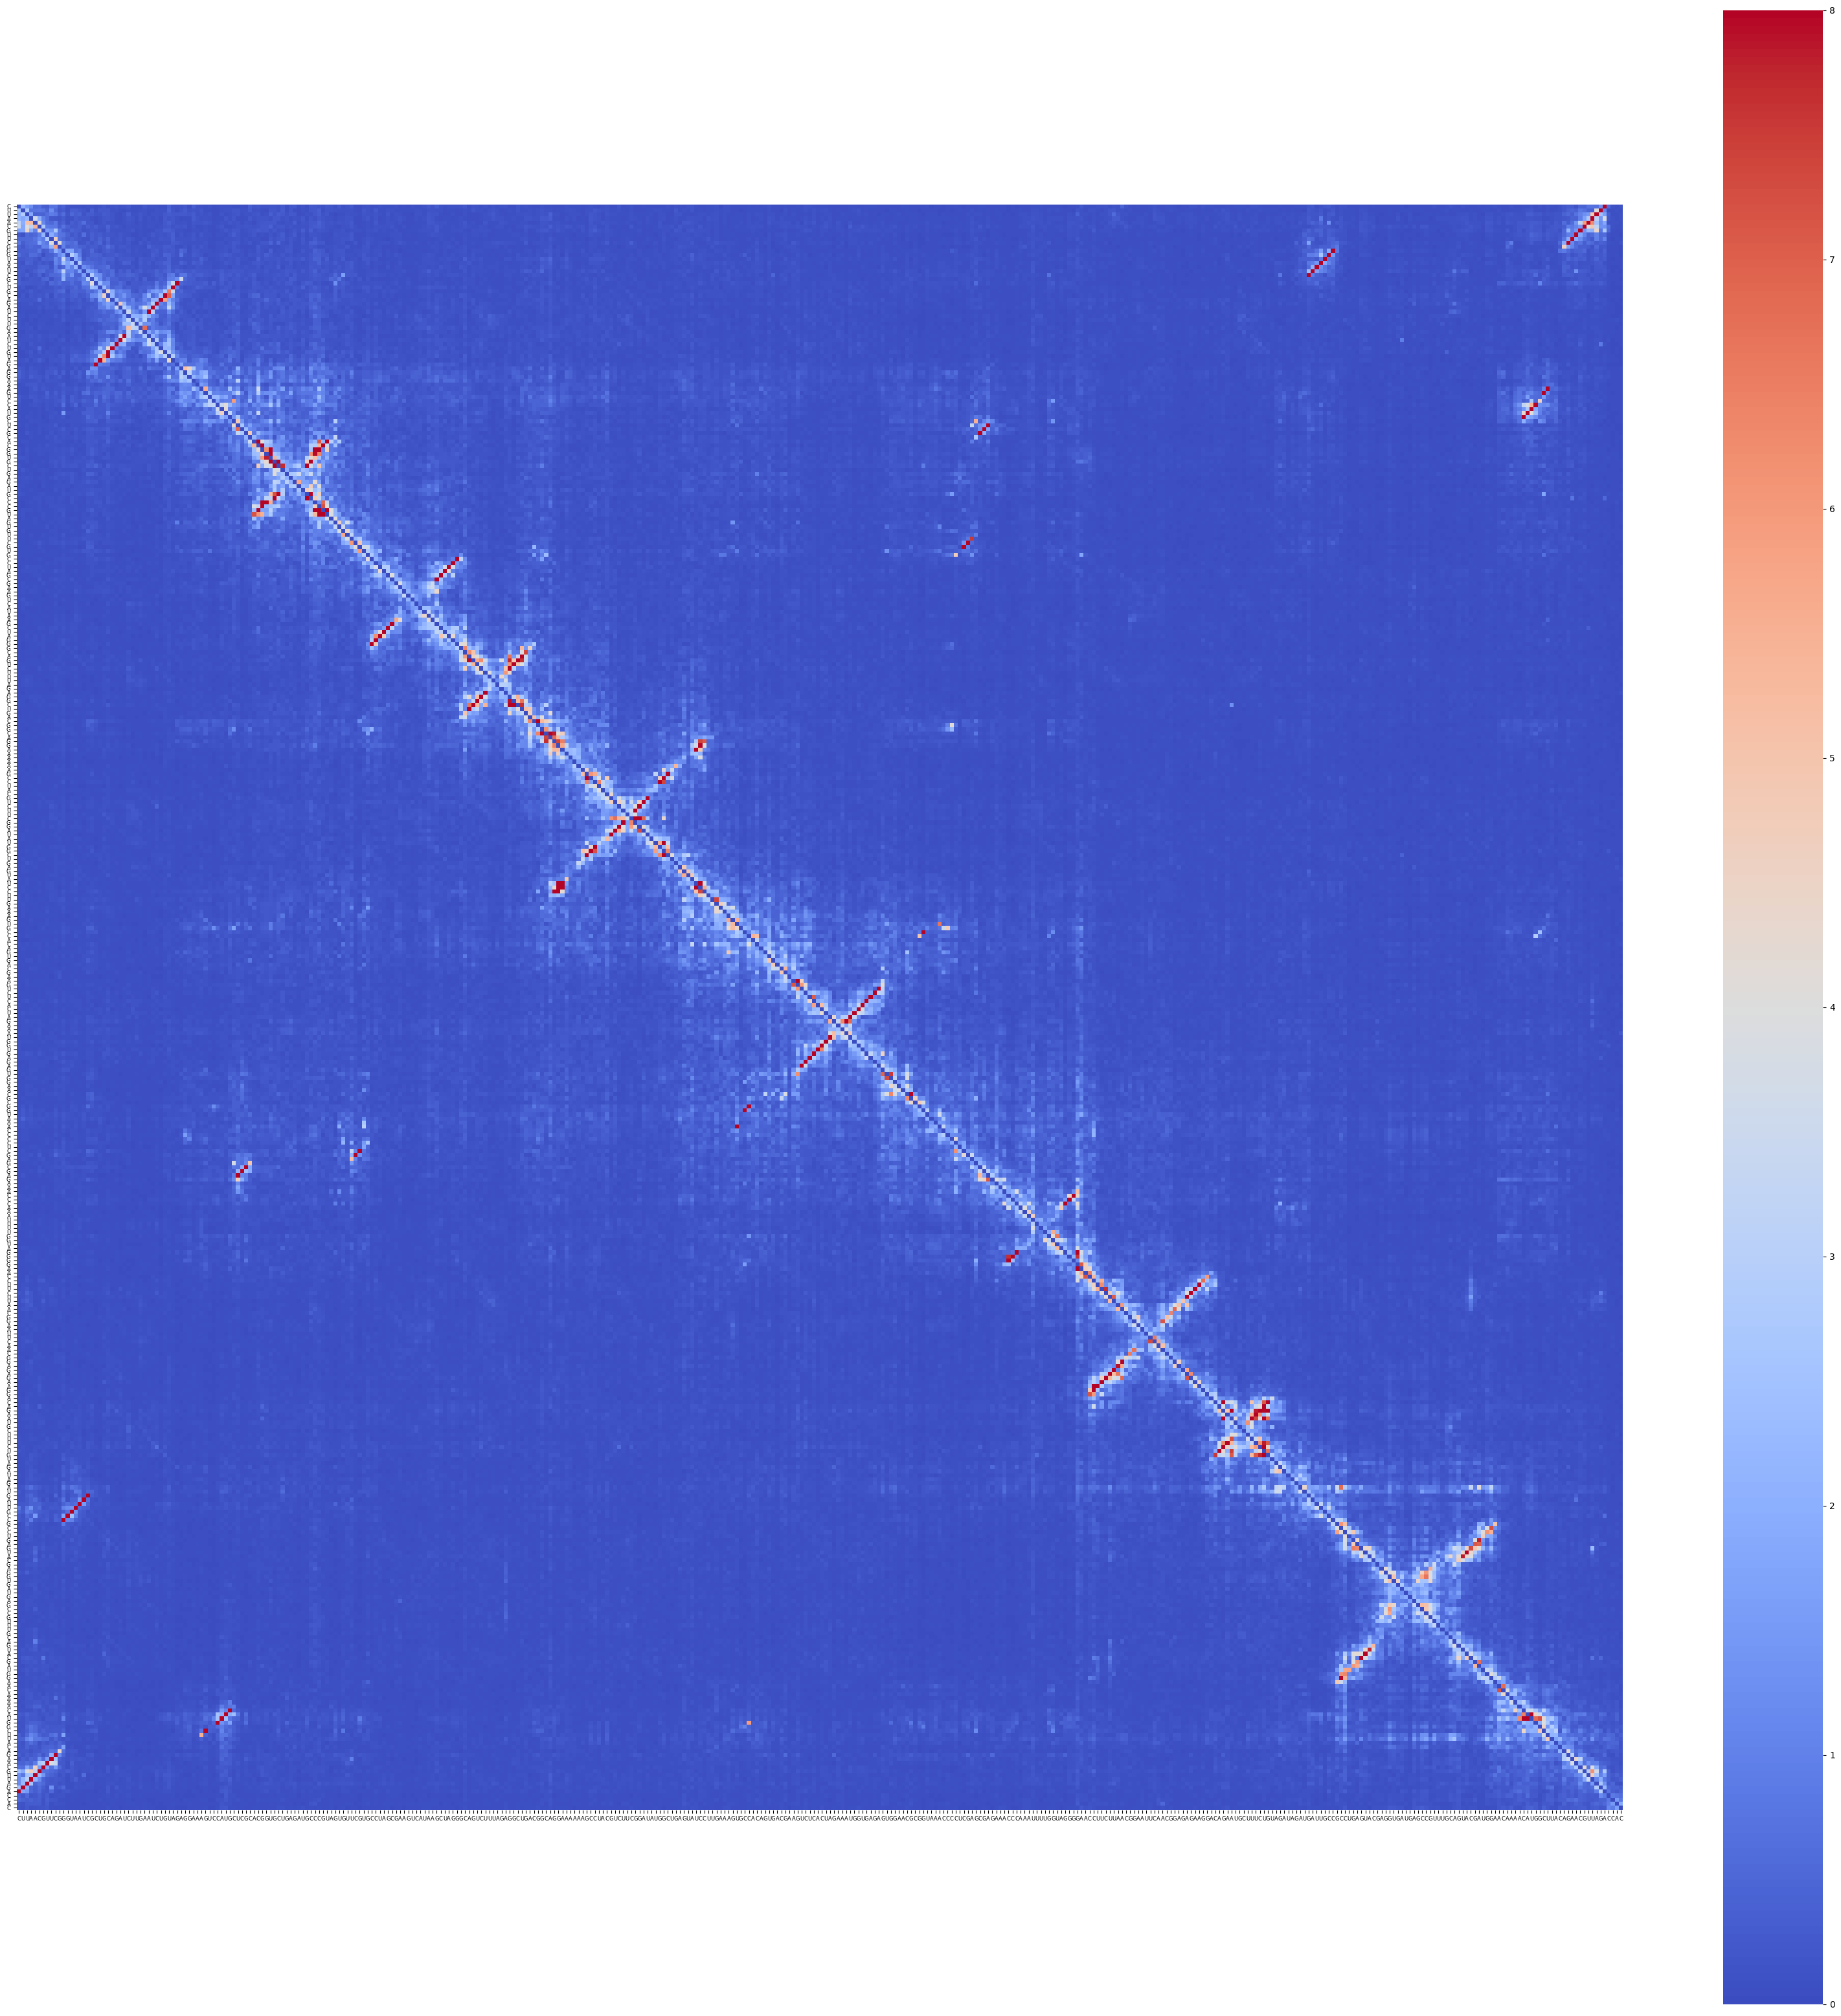

In [71]:
plot_map_with_seq(dep_map, RNA_seq, vmax=8, tick_label_fontsize=6, plot_size=40)

## SpeciesLM Metazoa

In [30]:
from transformers import AutoTokenizer, AutoConfig
from flash_attn.models.bert import BertModel, BertForPreTraining
import torch
import torch.nn as nn
from torch.amp import autocast
import tqdm

model_path = 'checkpoint-200000'
config = AutoConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = BertForPreTraining.from_pretrained(model_path, config)

In [31]:
device = "cuda"
model.to(device)
model.eval()

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4608, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(2, 768)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
    (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0): Block(
          (mixer): MHA(
            (rotary_emb): RotaryEmbedding()
            (Wqkv): FusedDense(in_features=768, out_features=2304, bias=True)
            (inner_attn): FlashSelfAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (inner_cross_attn): FlashCrossAttention(
              (drop): Dropout(p=0.1, inplace=False)
            )
            (out_proj): FusedDense(in_features=768, out_features=768, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (drop_path1): StochasticDepth(p=0.0, 

In [32]:
proxy_species = 'homo_sapiens'
assert proxy_species in tokenizer.get_vocab()

In [51]:
from datasets import Dataset
from transformers import DefaultDataCollator

def kmers(seq, k=6): #for codons, k = 6
    # splits a sequence into non-overlappnig k-mers
    return [seq[i:i + k] for i in range(0, len(seq), k) if i + k <= len(seq)]

def kmers_stride1(seq, k=6):
    # splits a sequence into overlapping k-mers
    return [seq[i:i + k] for i in range(0, len(seq)-k+1)]  

def tok_func_species(x, proxy_species, seq_col):
    res = tokenizer(proxy_species + " " +  " ".join(kmers_stride1(x[seq_col])))
    return res

def tok_func_species_rolling_masking(x, proxy_species):
    
    res = tokenizer(proxy_species + x['seq_masked'])
 
    return res

def get_dataloader(dataset, seq_col, shuffle = True, bs = 4, 
                   has_label=True, provide_covariates=True, rolling_masking=False):
    
    #tok_func = lambda x: tok_func_species(x, proxy_species, seq_col) 
    

    keys = [seq_col]
    
    if provide_covariates:
        dataset["covariates"] = [x.astype('float') for x in np.array(dataset[codon_vars[:-1] + signif_vars[:-4]])]
        keys.append('covariates')
    if has_label:
        dataset = dataset.rename(columns = {'log_hl' : 'label'})
        keys.append('label')
        
    ds = Dataset.from_pandas(dataset[keys]) 

    #tok_ds = ds.map(tok_func, batched=False,  num_proc=12)
    tok_ds = ds.map(lambda x: tok_func_species(x, proxy_species=proxy_species, seq_col=seq_col), batched=False,  num_proc=12) if not rolling_masking else ds.map(lambda x: tok_func_species_rolling_masking(x, proxy_species=proxy_species), batched=False,  num_proc=12)
    rem_tok_ds = tok_ds.remove_columns(seq_col)
    
    data_collator = DefaultDataCollator()
    data_loader = torch.utils.data.DataLoader(rem_tok_ds, batch_size=bs, num_workers = 4, shuffle = shuffle, collate_fn = data_collator)
    
    return data_loader

In [52]:
class ReconstructionModel(nn.Module):
    
    def __init__(self, lm, tokenizer, device=device, 
                 kmer_size = 6, 
                 left_special_tokens = 2,
                 right_special_tokens = 1,
                 only_predict_masked = False,
                 require_grad=False):
        super().__init__()
        self.lm = lm
        self.tokenizer = tokenizer
        self.require_grad = require_grad
        self.only_predict_masked = only_predict_masked
        self.kmer_size = kmer_size
        self.device = device
        self.left_special_tokens = left_special_tokens
        self.right_special_tokens = right_special_tokens
        self.create_prb_filter()
        
        self.word_embeddings = None
        self.hook_dict = {}
        
    def set_grad_computation(self, switch):
        self.require_grad = switch
        
    def set_word_embedding_hook(self):
        def getHook():
            def hook(model, input, output):
                output.retain_grad()
                self.word_embeddings = output
            return hook
        self.hook_dict["words"] = self.lm.bert.embeddings.word_embeddings.register_forward_hook(getHook())
        
    def create_prb_filter(self):
        """make a convolutional filter for each nt
        The way this works:
        Take the kmer ACGTGC which maps to token 739, its last nt is C
        This would be the prediction for the masked nucleotide from this kmer, if the kmer is the first in a masked span
        So the first row of column 739 searches for C, in other words filter_xyz = 1 for x = 0, y = 739, z = 2
        Equally, the second row of column 739 searches for G etc..."""
        vocab = tokenizer.get_vocab()
        kmer_list = ["".join(x) for x in itertools.product("ACGT",repeat=6)]
        nt_mapping = {"A":0,"C":1,"G":2,"T":3}
        prb_filter = np.zeros((self.kmer_size, 4**self.kmer_size, 4))
        for kmer in kmer_list:
            token = vocab[kmer] - 5 # there are 5 special tokens
            for idx, nt in enumerate(kmer):
                nt_idx = nt_mapping[nt]
                prb_filter[5-idx, token, nt_idx] = 1
        prb_filter = torch.from_numpy(prb_filter)
        self.prb_filter = prb_filter.to(self.device).float() # k, 4**k, 4
    
    @autocast(device)
    def forward(self, tokens):
        grad_context = contextlib.nullcontext() if self.require_grad else torch.no_grad() 
        with grad_context:
            predictions = self.lm(tokens)["prediction_logits"] # Dim: B, L_in, vocab_size
            logits = predictions[:,:,5:(5+self.prb_filter.shape[1])] # remove any non k-mer dims (there are 5 special tokens)
            kmer_preds = torch.softmax(logits,dim=2)
            # remove special tokens:
            kmer_preds = kmer_preds[:,(self.left_special_tokens):(kmer_preds.shape[1] - self.right_special_tokens),:]
            # pad to predict first k-1 and last k-1 nt
            kmer_pad = torch.zeros((kmer_preds.shape[0], (self.kmer_size-1), kmer_preds.shape[2]),device=self.device)
            kmer_preds = torch.concat([kmer_pad,kmer_preds,kmer_pad],axis=1)
            # reshape so that each span (representing one nucleotide) is its own entry
            kmer_preds = kmer_preds.unfold(dimension=1,size=self.kmer_size,step=1).swapaxes(2,3) # B, L_seq, k, 4**k
            # convert kmer predictions to nucleotide predictions
            nt_preds = kmer_preds.unsqueeze(-1).expand((kmer_preds.shape[0],kmer_preds.shape[1],kmer_preds.shape[2],kmer_preds.shape[3],4)) # B, L_seq, k, 4**k, 4
            nt_preds = (nt_preds * self.prb_filter).sum(axis=(2,3)) # B, L_seq, 4
            # renormalize so that it sums to one
            nt_prbs = nt_preds/self.kmer_size
            if self.only_predict_masked: # only record predictions for properly masked spans
                # find the properly masked spans
                # remove special tokens
                tokens = tokens[:,self.left_special_tokens:(tokens.shape[1] - self.right_special_tokens)]
                # pad with mask token (to ensure edge cases become spans)
                token_pad = torch.zeros((tokens.shape[0],self.kmer_size-1), dtype=torch.int64, device=self.device) + 4
                tokens = torch.concat([token_pad,tokens,token_pad],axis=1)
                # unfold to B, L_seq, k
                tokens = tokens.unfold(dimension=1,size=self.kmer_size,step=1)
                # find masked spans
                masked_positions = ((tokens == 4).sum(axis=2) == self.kmer_size)
                nt_prbs = nt_prbs * masked_positions.unsqueeze(-1) # mask
        return nt_prbs
    
    def mask_tokens(self, tokens):
        # create diagonal identity matrix of the same shape as basis for the masking
        diag_matrix = torch.eye(tokens.shape[1]).numpy()
        # propagate the ones to kmer-sized spans
        masked_indices = np.apply_along_axis(lambda m : np.convolve(m, [1] * self.kmer_size, mode = 'same' ),axis = 1, arr = diag_matrix).astype(bool)
        masked_indices = torch.from_numpy(masked_indices)
        # do not mask special tokens and do not repeat at edges (this math works for k = 6, unclear if it generalizes)
        masked_indices = masked_indices[(self.kmer_size//2 - 1)+self.left_special_tokens:-((self.kmer_size//2)+self.right_special_tokens)]
        masked_tokens = tokens.unsqueeze(1).expand(tokens.shape[0],masked_indices.shape[0],tokens.shape[1]).clone() # reshape
        masked_tokens[:,masked_indices] = 4 # mask
        return masked_tokens
    
    def predict_all_from_dataloader(self, data_loader):
        assert not self.only_predict_masked
        output_arrays = []
        for i, batch in tqdm.tqdm(enumerate(data_loader)):
            # get some tokenized sequences (B, L_in)
            tokens = batch['input_ids']
            # predict
            outputs = self(tokens.to(self.device)) # B, L_seq, 4
            output_arrays.append(outputs.cpu()) # send to cpu to conserve memory
        # rebuild to B, L_seq, 4
        predictions = torch.concat(output_arrays, axis=0)
        return predictions
    
    def predict_all_from_dataloader_masked(self, 
                                          data_loader,
                                          batch_size = 128):
        all_preds = []
        for i, group in enumerate(data_loader):
            output_arrays = []
            # get some tokenized sequences (B, L_in)
            tokens = group['input_ids']
            # mask them
            masked_tokens = self.mask_tokens(tokens)
            # remember the number of sequences (shape[0] = B) and number of maskings (shape[1] = n_masked)
            group_shape = masked_tokens.shape
            # reshape to B*n_masked, L_in
            masked_tokens = masked_tokens.reshape(masked_tokens.shape[0]*masked_tokens.shape[1], masked_tokens.shape[2])
            token_loader = torch.utils.data.DataLoader(masked_tokens, batch_size=batch_size, 
                                                       num_workers = 4, shuffle = False, collate_fn = None)
            # predict
            for j, batch in enumerate(token_loader):
                outputs = self(batch.to(self.device)) # b, L_seq, 4
                output_arrays.append(outputs.cpu()) # send to cpu to conserve memory
            # rebuild to B*n_masked, L_seq, 4
            predictions = torch.concat(output_arrays, axis=0)
            # reshape to B, n_masked, L_seq, 4
            predictions = predictions.reshape((group_shape[0],group_shape[1],predictions.shape[1],predictions.shape[2]))
            if self.only_predict_masked:
                predictions = predictions.sum(axis=1)
            all_preds.append(predictions)
        predictions = torch.concat(all_preds, axis=0)
        return predictions

In [53]:
import itertools

nuc_table = {"A" : 0, "C":1, "G":2, "T":3}

def mutate_sequence(seq):
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'T']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def compute_dependency_map(seq, batch_size=8, seq_col='seq', epsilon=1e-10):    
    dataset = mutate_sequence(seq)

    reconstructor = ReconstructionModel(model, tokenizer, require_grad=False)
    reconstructor.eval()

    dl = get_dataloader(dataset, shuffle = False, bs = batch_size, seq_col = seq_col, has_label=False, provide_covariates=False) #bs = batch_size
    snp_reconstruct = reconstructor.predict_all_from_dataloader(dl)
    snp_reconstruct = snp_reconstruct.detach().cpu().numpy()
    snp_reconstruct.shape

    # for the logit add the small value and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]


    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0


    return dep_map

Human LDLR 2kb 5' of the start codon

In [63]:
ldlr_five_prime_seq = 'CTTCTCTAGGTGATTGCTAATTACTTCTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTCACTCTGTCGCCCAGGCTGGAGTACAGTGGCGCAATCTCGTCTCACTGCAAACTCCACCTCCCGGGTTCACGCCATTCTCCTGCCTCAGCCTCCCGAGTAGCTGGGACTACAGGCACCCGCCACCACGCCCGGCTAATTTTTTGTATTTTTTTTTAGTAGAGGTGGGGTTTCACTGTGTTATCCAGGATGGTCTTGATCTCCTGACCTCGTGATCCACCTGCCTCAGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCATGCCCAGCCCGCTAATTATTTCAATTTGACCTTGACACTGAGCCTGCCAAGTAGGTTCAAGCATTTTGATGGCCCCTTTACAGGTTGGGAAAGCTAATTTATCTGTCCAAGGCCGAATTCTGAAACTGAGTCTTAACTGCCAAAAATTCTTATCATCAATTTCTTCTTCTGGGTTGGGCACAGTGGCTCATGCCTGTAAAGCCAGCAATTTGAGAGGCATCATGATGCAAGAGGAAGAGGATTGAGTGAAGCTAGGAGTTTGGGACCAGCCTGGGCAACATAGTGAGACCCCATCTATAAAAAAAAATTAAAAATTAGTTGGGCATGGTGGTGCACTCCTGTGGTCCTAGCTATTCAGGAGGCTGAGGTGGGAGGATTCCTTGAGCCCAGGGTTGACGCTGCAGAGAGCTGTGATCACGCCACTGCAGTCCAGCCTGAGTGACAGCTGGAAATAATGATAAATAAATAATAAATAATTATTTAAAAAATTATAATAAAAATAATTAAAAAATTATTTTCCCTGATTAATCTTTTTTTTTGTCCTTCTGAGAGTTCAATTTGTCCCTTTTCTGCCTGGTCTCCTAGGTTTCCCTAAAATCCTGCTGAGAGGTTAGCACTGCCTGCCAAAGTCAGTTTGCAAAATCCCAGAGAAATCCAGCTTATTCCTGGGGGAACCGCCAAGACTGCCCAGCCCTGTGTGGGGTTCAGGCAAGTTTCTCACATGTGCCTTTTTGGCAAGAGGCCTCTGGCAACCCCATGAGTCCCCAAAGAGACTCAATTCTAAAAGTTGGTCTCCACCAGCTCTCTGTGGCTTAGGGGTTCAAGTTCAACTGTGAAAGCCCTGTTTTGTTTTGATTTTGCTTTGAGGGAGAGGAAACCGCCCTTCTGTTTGTTCAACTCCTTCTCCTAAGGGGAGAAATCAATATTTACGTCCAGACTCCAGGTATCCGTACAATTGATTTTTCAGATGTTTATACTCAGCCAAAGGCGGGATCCCACAAAACAAAAAATATTTTTTTGGCTGTACTTTTGTGAAGATTTTATTTAAATTCCTGATTGATCAGTGTCTATTAGGTGATTTGGAATAACAATGTAAAAACAATATACAACGAAAGGAAGCTAAAAATCTATACACAATTCCTAGAAAGGAAAAGGCAAATATAGAAAGTGGCGGAAGTTCCCAACATTTTTAGTGTTTTCCTTTTGAGGCAGAGAGGACAATGGCATTAGGCTATTGGAGGATCTTGAAAGGCTGTTGTTATCCTTCTGTGGACAACAACAGCAAAATGTTAACAGTTAAACATCGAGAAATTTCAGGAGGATCTTTCAGAAGATGCGTTTCCAATTTTGAGGGGGCGTCAGCTCTTCACCGGAGACCCAAATACAACAAATCAAGTCGCCTGCCCTGGCGACACTTTCGAAGGACTGGAGTGGGAATCAGAGCTTCACGGGTTAAAAAGCCGATGTCACATCGGCCGTTCGAAACTCCTCCTCTTGCAGTGAGGTGAAGACATTTGAAAATCACCCCACTGCAAACTCCTCCCCCTGCTAGAAACCTCACATTGAAATGCTGTAAATGACGTGGGCCCCGAGTGCAATCGCGGGAAGCCAGGGTTTCCAGCTAGGACACAGCAGGTCGTGATCCGGGTCGGGACACTGCCTGGCAGAGGCTGCGAGCATG'

In [64]:
dep_map = compute_dependency_map(ldlr_five_prime_seq)
dep_map.shape

Map (num_proc=12):   0%|          | 0/6010 [00:00<?, ? examples/s]

752it [01:40,  7.45it/s]


(2003, 2003)

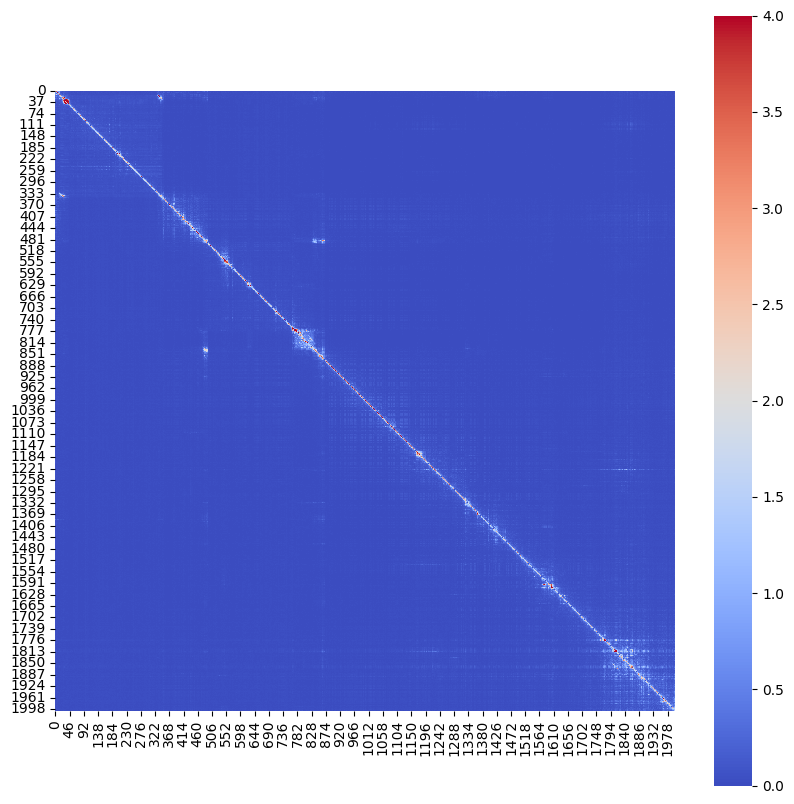

In [66]:
plot_map(dep_map,  vmax=4)

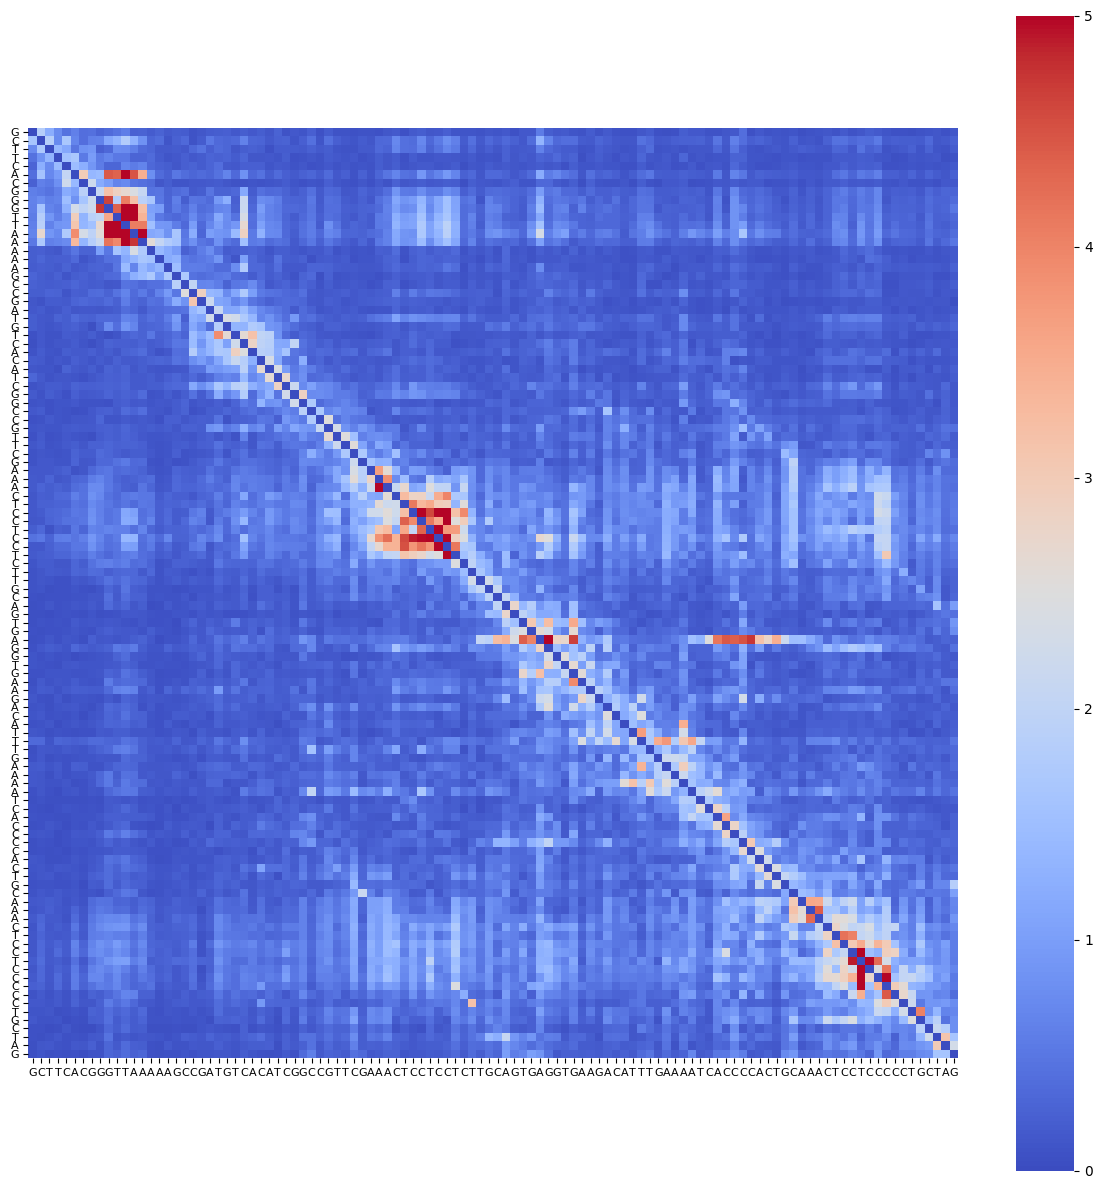

In [71]:
plot_map_with_seq(dep_map[1764: 1874,1764: 1874], ldlr_five_prime_seq[1764:1874], vmax=5, tick_label_fontsize=8, plot_size=15)

### Variant influence score

In [96]:
def compute_all_variants_influence_score(seq, batch_size=8, seq_col='seq', epsilon=1e-10):    
    dataset = mutate_sequence(seq)

    reconstructor = ReconstructionModel(model, tokenizer, require_grad=False)
    reconstructor.eval()

    dl = get_dataloader(dataset, shuffle = False, bs = batch_size, seq_col = seq_col, has_label=False, provide_covariates=False) #bs = batch_size
    snp_reconstruct = reconstructor.predict_all_from_dataloader(dl)
    snp_reconstruct = snp_reconstruct.detach().cpu().numpy()
    snp_reconstruct.shape

    # for the logit add the small value and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]


    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    variant_influence_score = snp_effect.max(axis=-1).sum(axis=1)/(snp_effect.shape[0]-1)

    return variant_influence_score

In [97]:
variant_influence_score = compute_all_variants_influence_score(ldlr_five_prime_seq)

Map (num_proc=12):   0%|          | 0/6010 [00:00<?, ? examples/s]

752it [01:40,  7.48it/s]


In [98]:
variant_influence_score.shape

(2003, 4)